In [1]:
using Gridap
using GridapMakie, CairoMakie, FileIO
using Gridap.FESpaces
using Gridap.ReferenceFEs
using Gridap.Arrays
using Gridap.Algebra
using Gridap.Geometry
using Gridap.Fields
using Gridap.CellData
using FillArrays
using Test
using InteractiveUtils
using PyPlot
using JSON3
using Dates 
# using Interpolations

In [2]:
include("Julia_functions/indicator_chi.jl")
include("Julia_functions/cost_fun.jl")
include("Julia_functions/gradient_descent.jl")
include("Julia_functions/solvers.jl")
include("Julia_functions/find.jl")
include("Julia_functions/res_plot.jl")
include("Julia_functions/get_domain.jl")
include("Julia_functions/get_price_temp.jl")
include("Julia_functions/post_processing.jl")

get_control_int (generic function with 1 method)

In [3]:
# --- Problemparametere ---
h = 1.0
k = 1.0
ρ = 1.0
c = 1.0
θ = 0.5
t0 = 0.0
h_wall = 1.0

# --- Manufactured solution og avledede størrelser ---
T_exact(x, t) = sin(x[1] + x[2] + t)
T_t(x, t) = cos(x[1] + x[2] + t)
ΔT(x, t) = -2 * sin(x[1] + x[2] + t)
Q(x, t) = T_t(x, t) - ΔT(x, t)


T_out_up(x, t) = cos(x[1] + x[2] + t) + T_exact(x, t)
T_out_up(t) = x -> T_out_up(x,t)

T_out_down(x, t) = -cos(x[1] + x[2] + t) + T_exact(x, t)
T_out_down(t) = x -> T_out_down(x,t)

T_out_left(x, t) = -cos(x[1] + x[2] + t) + T_exact(x, t)
T_out_left(t) = x -> T_out_left(x,t)

T_out_right(x, t) = cos(x[1] + x[2] + t) + T_exact(x, t)
T_out_right(t) = x -> T_out_right(x,t)


Qt(t) = x -> Q(x, t)

# --- Initialtilstand ---
TIni(x) = T_exact(x, t0)

function SEManufactured_error(dom,partn,Δt,tF)
    # --- Geometri og mesh ---
  domain = (0.0, dom, 0.0, dom)
  partition = (partn, partn)
  model = CartesianDiscreteModel(domain, partition)

  labels = get_face_labeling(model)
  add_tag_from_tags!(labels, "left", [1,3,7])
  add_tag_from_tags!(labels, "right", [2,4,8])
  add_tag_from_tags!(labels, "bottom", [5])
  add_tag_from_tags!(labels, "top", [6])

  Ω = Triangulation(model)
  Γ_up = BoundaryTriangulation(model, tags="top")
  Γ_down = BoundaryTriangulation(model, tags="bottom")
  Γ_left = BoundaryTriangulation(model, tags="left")
  Γ_right = BoundaryTriangulation(model, tags="right")

  order = 1
  degree = 2 * order
  dΩ = Measure(Ω, degree)
  dΓ_up = Measure(Γ_up, degree)
  dΓ_down = Measure(Γ_down, degree)
  dΓ_left = Measure(Γ_left, degree)
  dΓ_right = Measure(Γ_right, degree)

  # --- Rom og FE-definisjon ---
  reffe = ReferenceFE(lagrangian, Float64, order)

  Testspace = TestFESpace(model, reffe; conformity=:H1)
  Trialspace = TransientTrialFESpace(Testspace)

  Uspace = FESpace(model, reffe, conformity=:H1)


  # --- Svak form ---
  a_dt(t, dT, v) = ∫(c * dT * v * ρ) * dΩ

  a_SE(t, T, v) = ∫(k * ∇(T) ⋅ ∇(v)) * dΩ +
                  ∫(h_wall * T * v)dΓ_up +
                  ∫(h_wall * T * v)dΓ_down +
                  ∫(h_wall * T * v)dΓ_left +
                  ∫(h_wall * T * v)dΓ_right

  l_SE(t, v) = ∫(Qt(t) * v) * dΩ +
              ∫(T_out_up(t) * v*h_wall)dΓ_up +
              ∫(T_out_down(t) *v*h_wall)dΓ_down +
              ∫(T_out_left(t) *v*h_wall)dΓ_left +
              ∫(T_out_right(t) * v*h_wall)dΓ_right

  # --- Operator og løsning ---
  ls = LUSolver()
  solver = ThetaMethod(ls, Δt, θ)

  op = TransientLinearFEOperator((a_SE, a_dt), l_SE, Trialspace, Testspace, constant_forms=(true, true))

  T0 = interpolate(TIni, Trialspace)
  T = solve(solver, op, t0, tF, T0)
  tid = 0
  for (t,TT) in T
    tid = t
  end
  T_exact_end(x) = sin(x[1] + x[2] + tid)
  error = 0
  tid = 0
  for (t,TT) in T
      tmp = TT - T_exact_end
      error = ∑(∫(tmp*tmp)*dΩ)
      tid = t
  end
  return √(error)
end


# test = interpolate_everywhere(Tini, Uspace(t0))

# uh = T
# test(t) = x -> T_exact(x,t)

# if !isdir("tmp")
#     mkdir("tmp")
#   end
  
#   createpvd("results") do pvd
#     # pvd[0] = createvtk(Ω, "tmp/results_0" * ".vtu", cellfields=["u" => uh0])
#     for (tn, uhn) in uh

#         # TIni=interpolate_everywhere(T_exact, Uspace(tn))

#         pvd[tn] = createvtk(Ω, "tmp/results_$tn" * ".vtu", cellfields=["u" => uhn-test(tn)])
#         # pvd[tn] = createvtk(Ω, "tmp/results_$tn" * ".vtu", cellfields=["u" => test(tn)])

#     end
#   end

SEManufactured_error (generic function with 1 method)

In [4]:
a = SEManufactured_error(1,25,0.01,1)




0.005228033062781886

In [5]:
import Pkg; Pkg.add("Makie")

   Resolving package versions...
  No Changes to `C:\Users\henni\.julia\environments\v1.11\Project.toml`
  No Changes to `C:\Users\henni\.julia\environments\v1.11\Manifest.toml`


In [17]:
using Gridap
using CairoMakie
using Makie  # for Makie.log10

# --- Parameters ---
partns = [2,4, 8, 16,32,64]                  # Spatial resolution
dts = [0.5]
for i in 1:8
    push!(dts,dts[i]*0.5)
end


domn = 1.0
tF = 1.0

# --- Store results in a dictionary ---
errors_dict = Dict{Int, Vector{Float64}}()

for partn in partns
    errs = Float64[]
    for Δt in dts
        err = SEManufactured_error(domn, partn, Δt, tF)
        push!(errs, err)
        h1 = 1/partn
        println("partn = $partn, Δx = $h1, Δt = $Δt, error = $err")
    end
    errors_dict[partn] = errs
end



partn = 2, Δx = 0.5, Δt = 0.5, error = 0.2063528497831263
partn = 2, Δx = 0.5, Δt = 0.25, error = 0.12109368774611602
partn = 2, Δx = 0.5, Δt = 0.125, error = 0.07234833591551357
partn = 2, Δx = 0.5, Δt = 0.0625, error = 0.045343987923187314
partn = 2, Δx = 0.5, Δt = 0.03125, error = 0.03159198606515713
partn = 2, Δx = 0.5, Δt = 0.015625, error = 0.02500084646302386
partn = 2, Δx = 0.5, Δt = 0.0078125, error = 0.021924666655998723
partn = 2, Δx = 0.5, Δt = 0.00390625, error = 0.020480801493846304
partn = 2, Δx = 0.5, Δt = 0.001953125, error = 0.019789855860004115
partn = 4, Δx = 0.25, Δt = 0.5, error = 0.2017121504884644
partn = 4, Δx = 0.25, Δt = 0.25, error = 0.11339466142572935
partn = 4, Δx = 0.25, Δt = 0.125, error = 0.0626655466685302
partn = 4, Δx = 0.25, Δt = 0.0625, error = 0.03421207519492912
partn = 4, Δx = 0.25, Δt = 0.03125, error = 0.01920698856338377
partn = 4, Δx = 0.25, Δt = 0.015625, error = 0.011634363125228591
partn = 4, Δx = 0.25, Δt = 0.0078125, error = 0.00797056

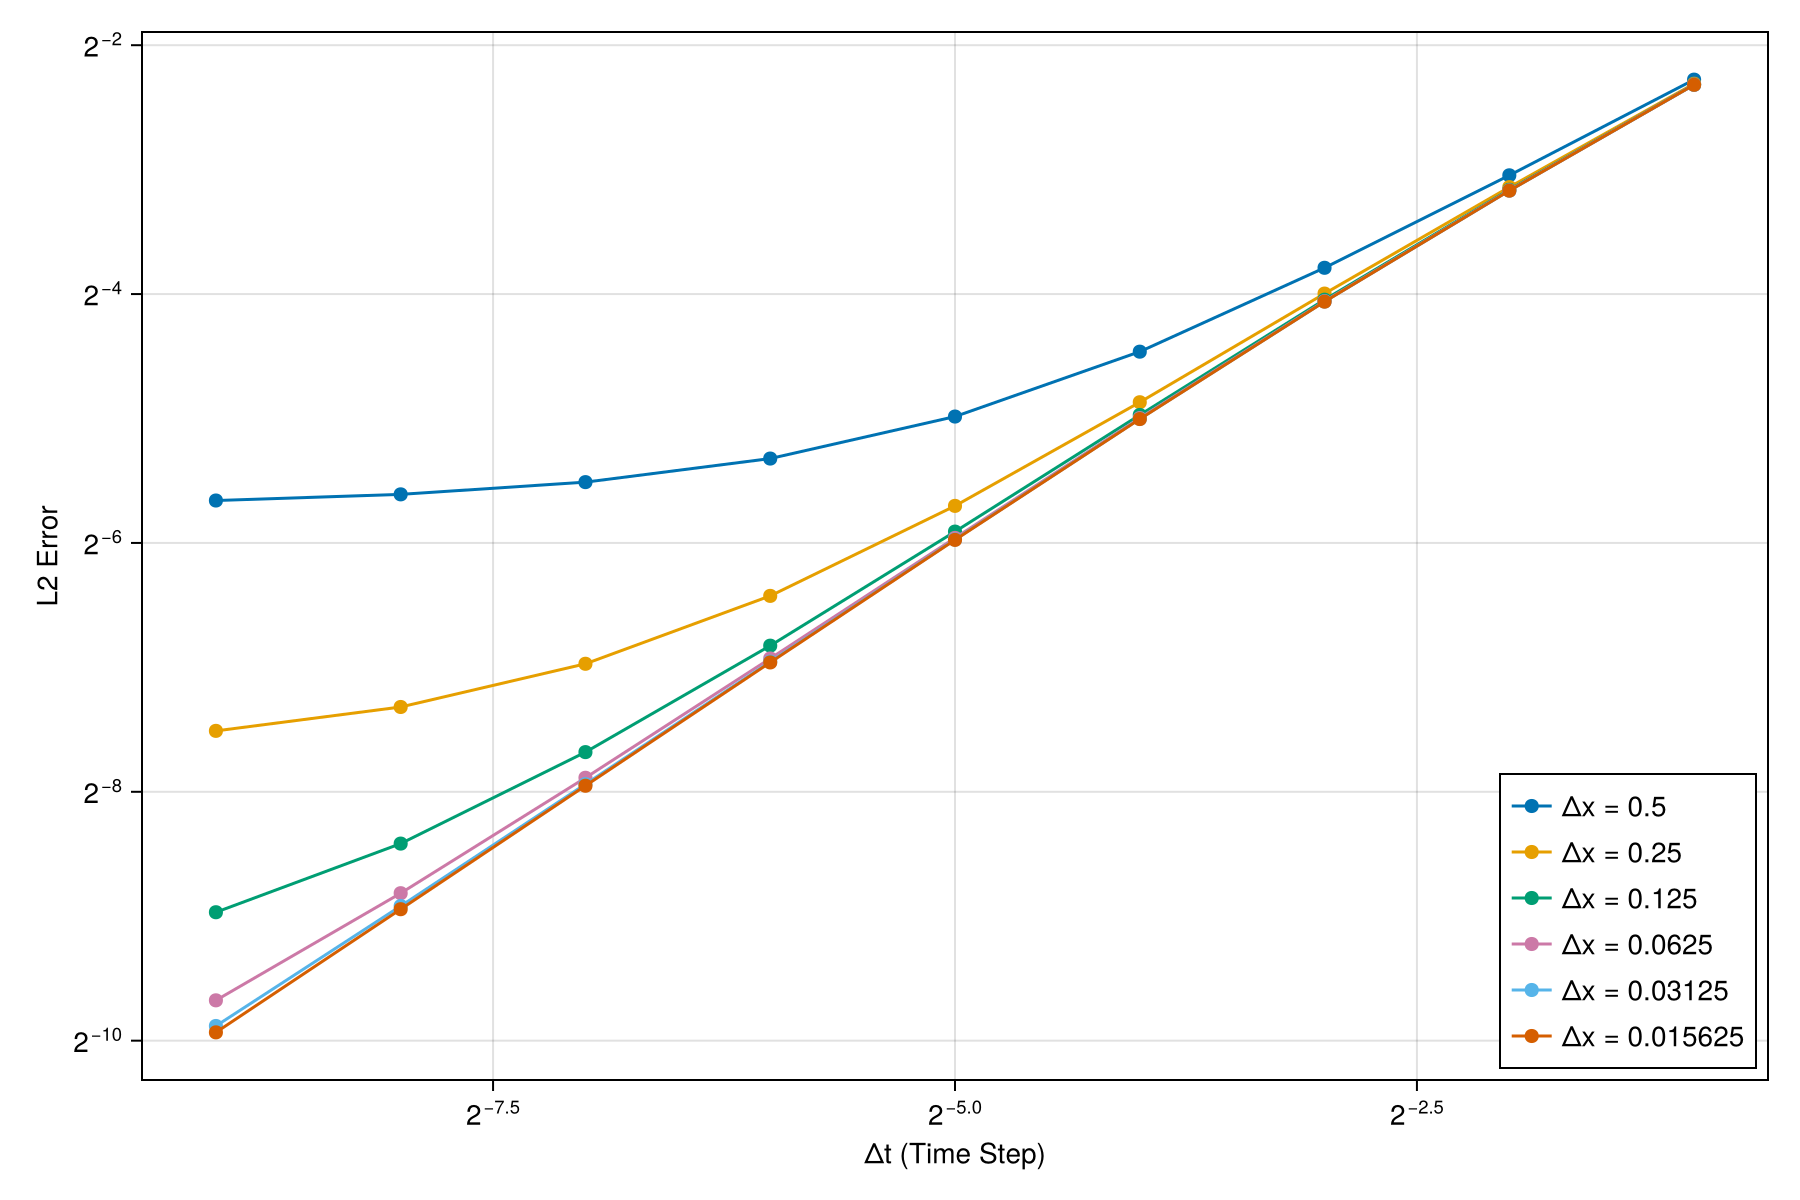

CairoMakie.Screen{IMAGE}


In [18]:
# --- Plotting ---
fig = CairoMakie.Figure(size = (900, 600))
ax = Axis(fig[1, 1];
    xscale = Makie.log2,
    yscale = Makie.log2,
    xlabel = "Δt (Time Step)",
    ylabel = "L2 Error"#,
    # title = "Time Convergence for Various Spatial Resolutions"
)

ax.xgridvisible = true
ax.ygridvisible = true

colors = Makie.wong_colors()

for (i, partn) in enumerate(partns)
    errs = errors_dict[partn]
    Δx= 1/partn
    CairoMakie.scatterlines!(ax, dts, errs;
        markersize = 10,
        label = "Δx = $Δx",
        color = colors[i]
    )
end

CairoMakie.axislegend(ax; position=:rb)
CairoMakie.display(fig)


In [19]:
CairoMakie.save("convergence_plot.png", fig)


CairoMakie.Screen{IMAGE}


In [8]:
# # Definer tidsstegene og løsningen
# T = [(t0, T0)]  # Start med initialbetingelsen
# for (t, TT) in zip(timesteps, computed_solutions)
#     push!(T, (t, FEFunction(Trialspace, copy(get_free_dof_values(TT)))))
# end

# # Lagre løsningene som VTK-filer og lag PVD-filen
# if !isdir("tmp_M")
#     mkdir("tmp_M")
# end

# createpvd("results_M") do pvd
#     # Lagre den initiale løsningen ved t = t0
#     pvd[0] = createvtk(Ω, "tmp_M/results_0.vtu", cellfields=["T" => T0])
    
#     # Lagre løsningene for hvert tidssteg
#     for (tn, (t, TT)) in enumerate(T)
#         # Hent FE-funksjonen for løsningen ved tidssteg t
#         Tn = FEFunction(Trialspace, copy(get_free_dof_values(TT)))
        
#         # Lagre løsningen som en VTK-fil
#         pvd[tn] = createvtk(Ω, "tmp_M/results_$tn.vtu", cellfields=["T" => Tn])
#     end
# end

